# Find Slope Break

### Import dependencies
* ***src.TrackProfileUtil*** - utility for developing track parameters (gline int, dist, etc.)
* ***src.SlopeBreak2*** - calculates the exact slope break

In [1]:
import shapely as sp
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import ICESat2GroundingLineMigration.IceSatHDF5Unpacker as unpack
import src.TrackProfileUtil as util
import src.SlopeBreak2 as slpbr
pd.options.mode.chained_assignment = None

/tmp/ipykernel_2100/1193224427.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


### Define bounds, granule, cycle & beam.
Then import track

In [2]:
rgt, name, cycle = 681, "gt2l", 11 # RGT and name information
study_area, lim = slpbr.studyArea("Bounds/bungen.gpkg")
xlim, ylim = lim

In [3]:
fullpath = f"Saves/{rgt}/{name}/Bung-{cycle}.json"
track = gpd.read_file(fullpath)

### Visualize raw flowslope vs. along track distance

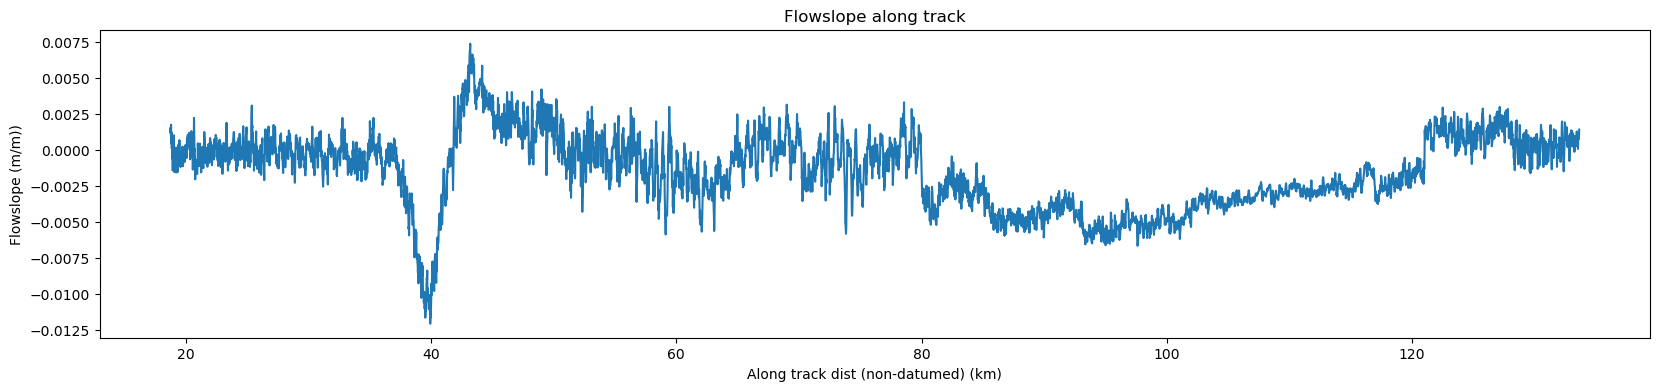

In [4]:
fig, ax = plt.subplots(1, 1, figsize = (20, 4))
ax.plot(track["along_track_dist"], track["slope"])
ax.set_title("Flowslope along track")
ax.set_ylabel("Flowslope (m/m))")
ax.set_xlabel("Along track dist (non-datumed) (km)")
plt.show()

### Import grounding line basemap

In [5]:
basemap = unpack.Basemap("BackgroundData/GroundedIce.gpkg")
gline_xy = util.gline_to_df(basemap.basemap_gpd, study_area)

### Locate break in slope
Debug = **True** returns:<br>
* Intersection (x, y) EPSG:3031
* Along track dist @ intersection
* Average & 2nd standard deviation for the whole track.
* Parameters for each potential Ib pick including quality score (qs)
* If an ice plain was predicted in the track
* Reduced set of potential Ib's (Based on individual parameters)
* Final pick (Point in reduced set with highest quality score)

In [6]:
out = slpbr.findIb(track, gline_xy, debug=True)
boolib = False
try:
    track, ibs, qs, plain = out
    if type(ibs) != list and type(ibs) != np.ndarray:
        ibs = [ibs]
    boolib = True
except:
    track = out

Found intersection at: -958332.1711151664,337868.5915340486
Along track dist @ intersection 22.084124475509405
TRACK PARAMS FOR 681-gt2l-11:
avg: -0.001453456378091869
2nd std dev: -0.006554892728803556 <-> 0.003647979972619818
PICKS:
loc:-1.99 slp:-0.0068 std:0.001628 rht:-0.0024 lft:-0.0014 r_s:0.001495 l_s:0.000293 qs:2.4635
loc:9.92 slp:0.0003 std:0.000781 rht:-0.0002 lft:0.0017 r_s:0.001739 l_s:0.00294 qs:2.8199
loc:29.5 slp:-0.0009 std:0.000995 rht:-0.001 lft:0.0003 r_s:0.001652 l_s:0.002793 qs:1.8082
loc:39.22 slp:-0.0015 std:0.001473 rht:-0.0029 lft:-0.0002 r_s:0.001169 l_s:0.002131 qs:2.9977
loc:76.02 slp:-0.002 std:0.000641 rht:-0.0016 lft:-0.0024 r_s:0.000585 l_s:0.001529 qs:0.7712
loc:-0.28 slp:-0.0067 std:0.002116 rht:0.0019 lft:-0.0044 r_s:0.001316 l_s:0.000345 qs:2.6123
loc:23.62 slp:-0.0013 std:0.000917 rht:0.0002 lft:-0.0022 r_s:0.001963 l_s:0.002712 qs:2.7837
loc:34.67 slp:-0.0011 std:0.000683 rht:-0.0003 lft:-0.0011 r_s:0.001046 l_s:0.002811 qs:1.937
loc:80.17 slp:-0

### Visualize dist to grounding line
Distance from the grounding line is computed using a simple process to determine if the value should be negative or positive. Because of this there are often discontinuties in the data, (jump from + to - or vice versa) where the track does not actually cross the grounding line. This is an artifact of the algorithm and does not influence final outcomes.

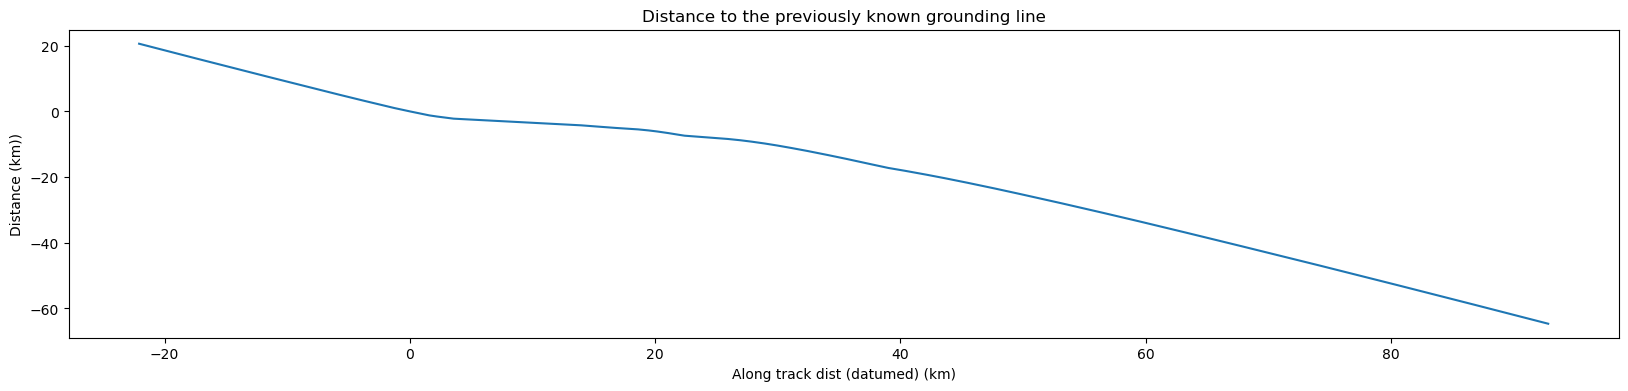

In [7]:
fig, ax = plt.subplots(1, 1, figsize = (20, 4))
ax.plot(track["along_dist"], track["gline_dist"])
ax.set_title("Distance to the previously known grounding line")
ax.set_ylabel("Distance (km))")
ax.set_xlabel("Along track dist (datumed) (km)")
plt.show()

### Visualize elevation

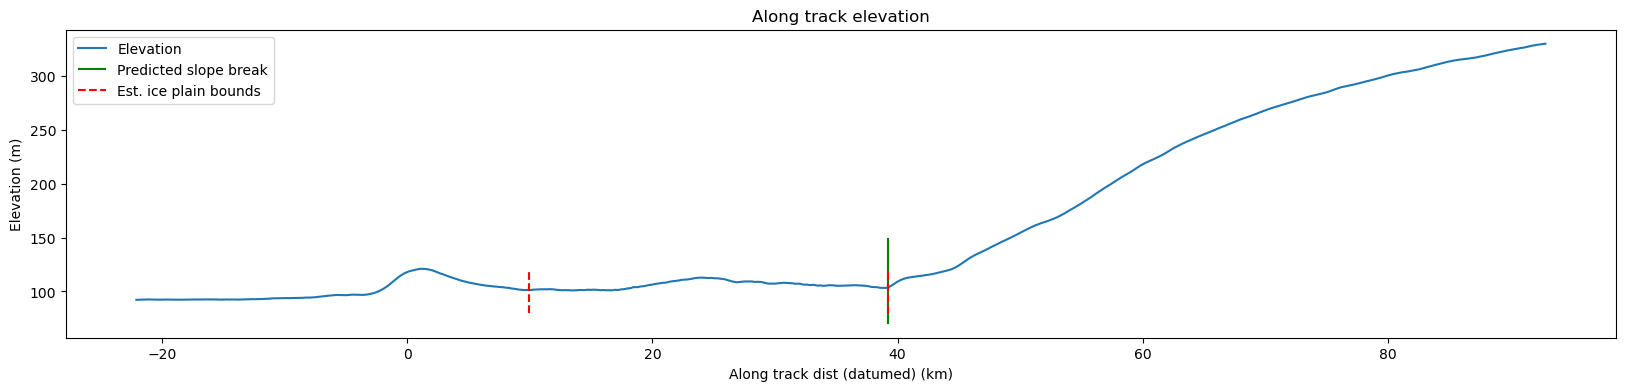

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (20, 4))
ax.plot(track["along_dist"], track["h_li"], label="Elevation")
if boolib == True:
    for ib in ibs:
        ax.vlines(ib, 70, 150, color="green", label="Predicted slope break")
    if plain:
        ax.vlines(plain, 80, 120, linestyle="dashed", color="red", label="Est. ice plain bounds")
ax.set_title("Along track elevation")
ax.set_ylabel("Elevation (m)")
ax.set_xlabel("Along track dist (datumed) (km)")
plt.legend()
plt.show()

### Visualize flowslope

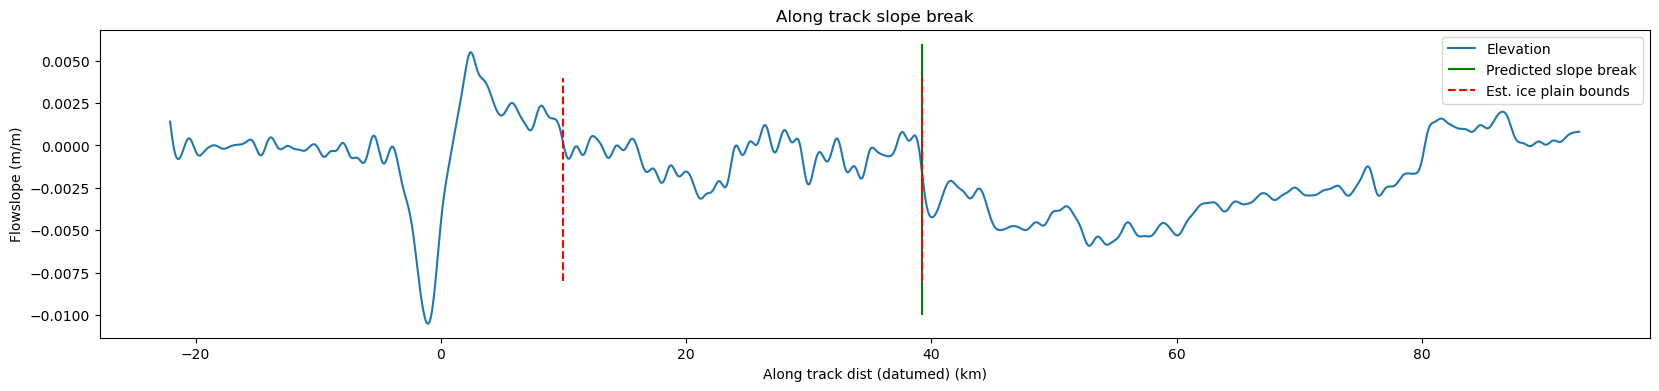

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (20, 4))
ax.plot(track["along_dist"], track["slope-filt"], label="Elevation")
if boolib == True:
    for ib in ibs:
        ax.vlines(ib, -0.01, 0.006, color="green", label="Predicted slope break")
    if plain:
        ax.vlines(plain, -0.008, 0.004, linestyle="dashed", color="red", label="Est. ice plain bounds")
ax.set_title("Along track slope break")
ax.set_ylabel("Flowslope (m/m)")
ax.set_xlabel("Along track dist (datumed) (km)")
plt.legend()
plt.show()

### Find XY of intersection & plain

In [10]:
xys = []

for ib in ibs:
    nearest_id = slpbr.find_nearest(track["along_dist"], ib)
    xys.append((track.iloc[nearest_id]["x"], track.iloc[nearest_id]["y"]))
    print(f"Ib @ {xys[-1]}")
    
pxys = []
if plain:
    for p in plain:
        nearest_id = slpbr.find_nearest(track["along_dist"], p)
        pxys.append((track.iloc[nearest_id]["x"], track.iloc[nearest_id]["y"]))
        print(f"Plain @ {pxys[-1]}")
    pxys = np.array(pxys)

Ib @ (-925196.1596375114, 316866.46125336306)
Plain @ (-949943.7142135273, 332547.6147817938)
Plain @ (-925196.1596375114, 316866.46125336306)


### Final visualization

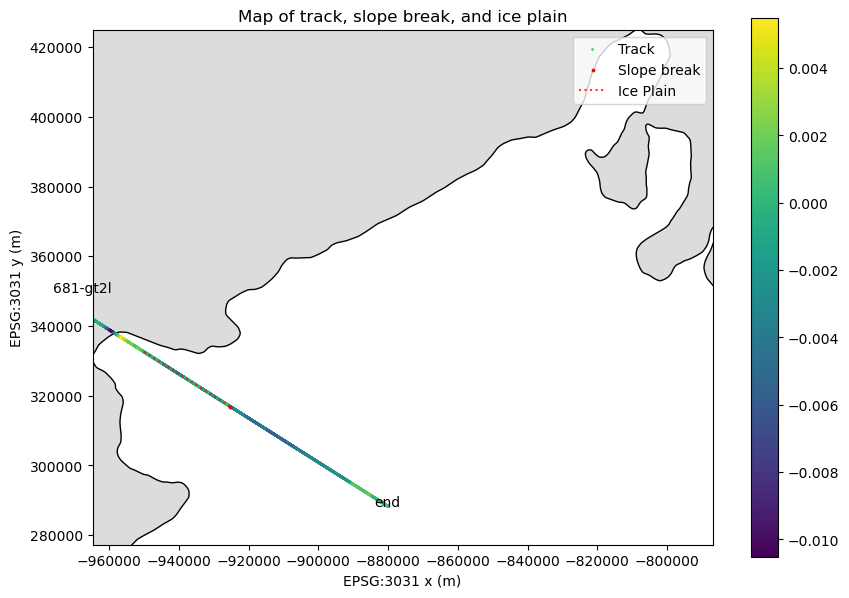

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
range_cnt = 20

ax.set_facecolor("gainsboro")
basemap.basemap_gpd.plot(ax=ax, color="white", edgecolor="black")

x, y = np.array(track["x"]), np.array(track["y"])
sc = ax.scatter(x, y, s=1, c = track["slope-filt"], label="Track")
plt.colorbar(sc, shrink=0.7)
plt.text(x[0]+1e3,y[0], s=f"{rgt}-{name}")
plt.text(x[-1]-4e3,y[-1], s="end")

for xy in xys:
    ax.scatter(xy[0], xy[1], color="red", s = 3, label="Slope break")
    
#plot plain
if len(pxys) > 0:
    ax.plot(pxys[:, 0], pxys[:, 1], linestyle="dotted", color="red", alpha=0.8, label="Ice Plain") 
    
ax.set_title("Map of track, slope break, and ice plain")
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel("EPSG:3031 x (m)")
ax.set_ylabel("EPSG:3031 y (m)")

plt.legend()

plt.xlim(gline_xy["x"].min(), gline_xy["x"].max())
plt.ylim(gline_xy["y"].min(), gline_xy["y"].max())
    
plt.show()